In [2]:
!pip install riotwatcher
!pip install pyspark

     |████████████████████████████████| 56 kB 2.6 MB/s 
     |████████████████████████████████| 281.3 MB 40 kB/s 
     |████████████████████████████████| 198 kB 54.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=c4d46dcf8e88c987114d64215274aa506eff63f90271e650ea4c95cd92af85b3
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
from riotwatcher import LolWatcher
import pyspark
api_key='RGAPI-3a40a643-54e7-4635-84ca-ba4d7377ca59'
watcher = LolWatcher(api_key)
region = 'EUN1'


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Initilize Spark Session

In [5]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("lol").getOrCreate()
sc = spark.sparkContext
#matches_data = spark.read.json("drive/MyDrive/one_big", multiLine=False)

# Read data from Google Drive

In [6]:
matches_data = spark.read.json("drive/MyDrive/one_big", multiLine=False)

In [7]:
matchs_num=matches_data.count()
matchs_num

2480

# Win-Pick-Ban Computation - wpb Matrix

In [11]:
def Extract_participant_data_from_matches(file_contain_matches):
        participants = file_contain_matches["info"]["participants"]
        participants_information = [{"assists":each_participant["assists"],
                                     "teamId":each_participant["teamId"],
                                     "championId":each_participant["championId"],
                                     "championName":each_participant["championName"],
                                     "summonerName":each_participant["summonerName"],
                                     "win":each_participant["teamId"],
                                     "kills":each_participant["kills"],
                                     "deaths":each_participant["deaths"],
                                     "doubleKills":each_participant["doubleKills"],
                                     "tripleKills":each_participant["tripleKills"],
                                     "quadraKills":each_participant["quadraKills"],
                                     "pentaKills":each_participant["pentaKills"],
                                     "unrealKills":each_participant["unrealKills"],
                                     "largestMultiKill":each_participant["largestMultiKill"],
                                     "largestKillingSpree":each_participant["largestKillingSpree"],
                                     "largestCriticalStrike":each_participant["largestCriticalStrike"],
                                     "longestTimeSpentLiving":each_participant["longestTimeSpentLiving"],
                                     "totalDamageDealt":each_participant["totalDamageDealt"],
                                     "magicDamageDealt":each_participant["magicDamageDealt"],
                                     "physicalDamageDealt":each_participant["physicalDamageDealt"],
                                     "trueDamageDealt":each_participant["trueDamageDealt"],
                                     "totalDamageDealtToChampions":each_participant["totalDamageDealtToChampions"],
                                     "magicDamageDealtToChampions":each_participant["magicDamageDealtToChampions"],
                                     "physicalDamageDealtToChampions":each_participant["physicalDamageDealtToChampions"],
                                     "trueDamageDealtToChampions" :each_participant["trueDamageDealtToChampions"],
                                     "totalHeal" :each_participant["totalHeal"],
                                     "totalUnitsHealed" :each_participant["totalUnitsHealed"],
                                     "damageSelfMitigated" :each_participant["damageSelfMitigated"],
                                     "damageDealtToObjectives" :each_participant["damageDealtToObjectives"],
                                     "damageDealtToTurrets" :each_participant["damageDealtToTurrets"],
                                     "visionScore" :each_participant["visionScore"],
                                     "timeCCingOthers" :each_participant["timeCCingOthers"],
                                     "totalDamageTaken" :each_participant["totalDamageTaken"],
                                     "magicDamageTaken" :each_participant["magicDamageTaken"],
                                     "physicalDamageTaken" :each_participant["physicalDamageTaken"],
                                     "trueDamageTaken" :each_participant["trueDamageTaken"],
                                     "goldEarned" :each_participant["goldEarned"],
                                     "goldSpent" :each_participant["goldSpent"],
                                     "turretKills" :each_participant["turretKills"],
                                     "inhibitorKills" :each_participant["inhibitorKills"],
                                     "totalMinionsKilled" :each_participant["totalMinionsKilled"],
                                     "neutralMinionsKilled" :each_participant["neutralMinionsKilled"],
                                     "totalTimeCCDealt" :each_participant["totalTimeCCDealt"]} for each_participant in participants]
        return participants_information

def wpb_matrix(match):
  champions_rates = []
  for part in match["info"]["participants"]:
    if(part["teamId"] == 100): team_number = 0
    else: team_number = 1
    if match["info"]["teams"][team_number]["win"]:
      stat="Won"
    else:
      stat="Lose"
    champions_rates.append((part["championId"], stat))
  
  for team in match["info"]["teams"]:
    for ban in team["bans"]:
      if(ban["championId"] != None):
        champions_rates.append((ban["championId"],"Banned"))

  return champions_rates

def calculate_rates(static,no_matches):
  banned = static.count("Banned")
  won = static.count("Won")
  lose = static.count("Lose")
  total_played_games = won+lose
  if(total_played_games):
    return [banned/no_matches, total_played_games/no_matches, won/total_played_games, lose/total_played_games]
  else:
    return [banned/no_matches, "not_complete", "not_complete"]
  
def show(name,val,x_name,y_name,tit):
    fig = plt.figure(figsize = (10, 5))
    
    # creating the bar plot
    plt.bar(name, val, color ='maroon',
            width = 0.4)
    
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title(tit)
    plt.show()

In [346]:
wpb_champion = matches_data.rdd.flatMap(wpb_matrix)
by_champion = wpb_champion.groupByKey().mapValues(list)
wpb_rates = by_champion.map(lambda x:(x[0], calculate_rates(x[1],matchs_num))).filter(lambda x: x[1][2] is not 'not_complete')
champion_rates = wpb_rates.collect()
'''
in champion_rates 

(Champion id , [ban rate , pick rate , win rate ,lose rate])
'''

def get_champions_name(_id):
    """
    this functions takes an _id and returns the associate champions name
    :param _id: any integer from 1 to 555. if there is a champion, it will return the name.
    :return: champions name
    """
    all_champion_id = {
        1: 'Annie',
        2: 'Olaf',
        3: 'Galio',
        4: 'Twisted Fate',
        5: 'Xin Zhao',
        6: 'Urgot',
        7: 'LeBlanc',
        8: 'Vladimir',
        9: 'Fiddlesticks',
        10: 'Kayle',
        11: 'Master Yi',
        12: 'Alistar',
        13: 'Ryze',
        14: 'Sion',
        15: 'Sivir',
        16: 'Soraka',
        17: 'Teemo',
        18: 'Tristana',
        19: 'Warwick',
        20: 'Nunu & Willump',
        21: 'Miss Fortune',
        22: 'Ashe',
        23: 'Tryndamere',
        24: 'Jax',
        25: 'Morgana',
        26: 'Zilean',
        27: 'Singed',
        28: 'Evelynn',
        29: 'Twitch',
        30: 'Karthus',
        31: "Cho'Gath",
        32: 'Amumu',
        33: 'Rammus',
        34: 'Anivia',
        35: 'Shaco',
        36: 'Dr.Mundo',
        37: 'Sona',
        38: 'Kassadin',
        39: 'Irelia',
        40: 'Janna',
        41: 'Gangplank',
        42: 'Corki',
        43: 'Karma',
        44: 'Taric',
        45: 'Veigar',
        48: 'Trundle',
        50: 'Swain',
        51: 'Caitlyn',
        53: 'Blitzcrank',
        54: 'Malphite',
        55: 'Katarina',
        56: 'Nocturne',
        57: 'Maokai',
        58: 'Renekton',
        59: 'JarvanIV',
        60: 'Elise',
        61: 'Orianna',
        62: 'Wukong',
        63: 'Brand',
        64: 'LeeSin',
        67: 'Vayne',
        68: 'Rumble',
        69: 'Cassiopeia',
        72: 'Skarner',
        74: 'Heimerdinger',
        75: 'Nasus',
        76: 'Nidalee',
        77: 'Udyr',
        78: 'Poppy',
        79: 'Gragas',
        80: 'Pantheon',
        81: 'Ezreal',
        82: 'Mordekaiser',
        83: 'Yorick',
        84: 'Akali',
        85: 'Kennen',
        86: 'Garen',
        89: 'Leona',
        90: 'Malzahar',
        91: 'Talon',
        92: 'Riven',
        96: "Kog'Maw",
        98: 'Shen',
        99: 'Lux',
        101: 'Xerath',
        102: 'Shyvana',
        103: 'Ahri',
        104: 'Graves',
        105: 'Fizz',
        106: 'Volibear',
        107: 'Rengar',
        110: 'Varus',
        111: 'Nautilus',
        112: 'Viktor',
        113: 'Sejuani',
        114: 'Fiora',
        115: 'Ziggs',
        117: 'Lulu',
        119: 'Draven',
        120: 'Hecarim',
        121: "Kha'Zix",
        122: 'Darius',
        126: 'Jayce',
        127: 'Lissandra',
        131: 'Diana',
        133: 'Quinn',
        134: 'Syndra',
        136: 'AurelionSol',
        141: 'Kayn',
        142: 'Zoe',
        143: 'Zyra',
        145: "Kai'sa",
        147: "Seraphine",
        150: 'Gnar',
        154: 'Zac',
        157: 'Yasuo',
        161: "Vel'Koz",
        163: 'Taliyah',
        166: "Akshan",
        164: 'Camille',
        201: 'Braum',
        202: 'Jhin',
        203: 'Kindred',
        222: 'Jinx',
        223: 'TahmKench',
        234: 'Viego',
        235: 'Senna',
        236: 'Lucian',
        238: 'Zed',
        240: 'Kled',
        245: 'Ekko',
        246: 'Qiyana',
        254: 'Vi',
        266: 'Aatrox',
        267: 'Nami',
        268: 'Azir',
        350: 'Yuumi',
        360: 'Samira',
        412: 'Thresh',
        420: 'Illaoi',
        421: "Rek'Sai",
        427: 'Ivern',
        429: 'Kalista',
        432: 'Bard',
        497: 'Rakan',
        498: 'Xayah',
        516: 'Ornn',
        517: 'Sylas',
        526: 'Rell',
        518: 'Neeko',
        523: 'Aphelios',
        555: 'Pyke',
        875: "Sett",
        711: "Vex",
        777: "Yone",
        887: "Gwen",
        876: "Lillia",



    }
    if _id in all_champion_id:
        return all_champion_id.get(_id)
    else: return all_champion_id


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
top_five_banned_champions = sorted(champion_rates, key = lambda x: x[1][0], reverse = True)[:5] 
top_five_picked_champions = sorted(champion_rates, key = lambda x: x[1][1], reverse = True)[:5] 
top_five_winning_champions = sorted(champion_rates, key = lambda x: x[1][2], reverse = True)[5:10] 
top_five_losing_champions = sorted(champion_rates, key = lambda x: x[1][3], reverse = True)[5:10] 
def get_name_rate(rate):
    banned_names = [get_champions_name(rate[0][0]), get_champions_name(rate[1][0]),get_champions_name(rate[2][0]),get_champions_name(rate[3][0]),get_champions_name(rate[4][0])]
    banned_values = [rate[0][1][0],rate[1][1][0],rate[2][1][0]
                    ,rate[3][1][0],rate[4][1][0]]
    return banned_names , banned_values


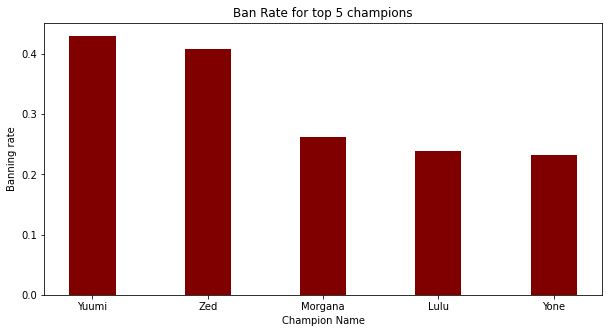

In [ ]:
ban_name,ban_val=get_name_rate(top_five_banned_champions)
show(ban_name,ban_val,"Champion Name","Banning rate", "Ban Rate for top 5 champions")

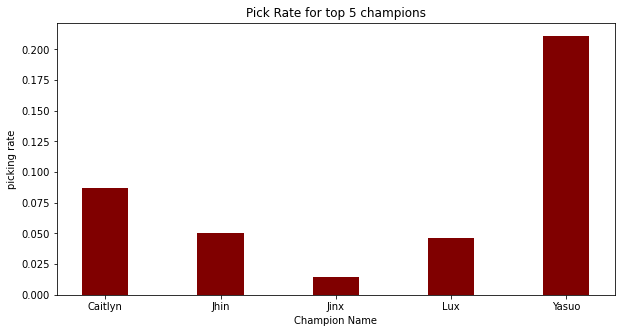

In [ ]:
pick_name,pick_val=get_name_rate(top_five_picked_champions)
show(pick_name,pick_val,"Champion Name","picking rate", "Pick Rate for top 5 champions")

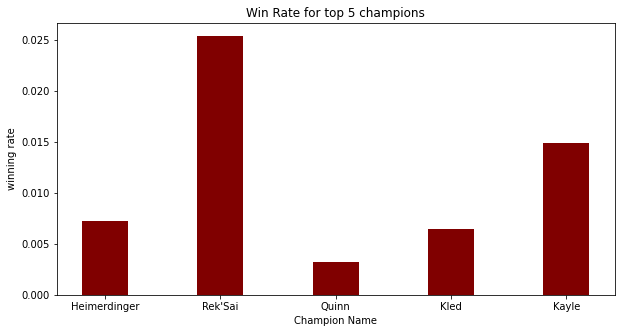

In [ ]:
def scale(lis,num):
   return [i * num for i in lis]

win_name,win_val=get_name_rate(top_five_winning_champions)
show(win_name,win_val,"Champion Name","winning rate", "Win Rate for top 5 champions")

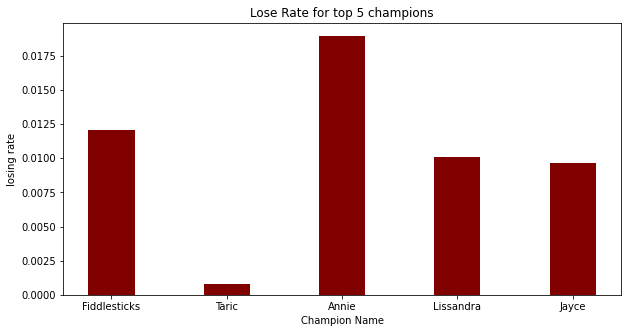

In [ ]:
lose_name,lose_val=get_name_rate(top_five_losing_champions)
show(lose_name,lose_val,"Champion Name","losing rate", "Lose Rate for top 5 champions")

# Item Win,Pick Rates Computation 

In [8]:
import json
#!cp items.json /content/drive/MyDrive
items_id={}
with open('/content/drive/MyDrive/items.json', 'r') as data_file:
    json_data = data_file.read()

data = json.loads(json_data)

for it in data:
  i={it['id']:it['name']}
  items_id.update(i)

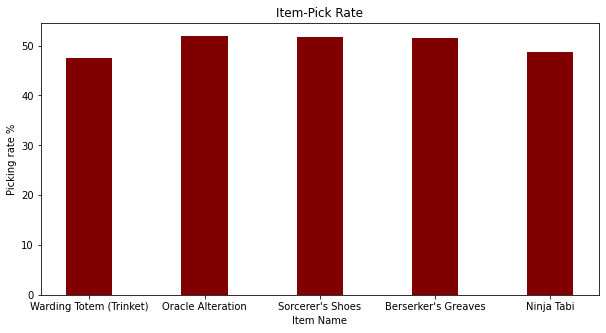

In [49]:
import matplotlib.pyplot as plt

def item(match):
  '''
  (items(0-6),winorlose)
  '''
  item_win=[]
  for part in match["info"]["participants"]:
    for item_num in range(7):
      item_win.append((part["item"+str(item_num)],part["win"]))
  return item_win

def calculate_item_rates(static,matchs_num):
  win_count = static.count(True)
  lose_count = static.count(False)
  total_played_games = win_count+lose_count
  return [win_count/total_played_games, len(static)/matchs_num]

def get_name_value_win_rate(rate):
    banned_names = [items_id.get(str(rate[0][0])), items_id.get(str(rate[1][0])),items_id.get(str(rate[2][0])),items_id.get(str(rate[3][0])),items_id.get(str(rate[4][0]))]
    banned_values = [rate[0][1][0],rate[1][1][0],rate[2][1][0]
                    ,rate[3][1][0],rate[4][1][0]]
    return banned_names , banned_values

def scale(lis,num):
   return [i * num for i in lis]

items = matches_data.rdd.flatMap(item).groupByKey().mapValues(list)
item_rates = items.map(lambda x:(x[0], calculate_item_rates(x[1],matchs_num))).filter(lambda x: x[0] is not None)
item_rates_list =  item_rates.collect()
top_five_picked_items=sorted(item_rates_list, key = lambda x: x[1][1], reverse = True)[1:6]
names,values=get_name_value_win_rate(top_five_picked_items)
show(names,scale(values,100),"Item Name","Picking rate %","Item-Pick Rate")


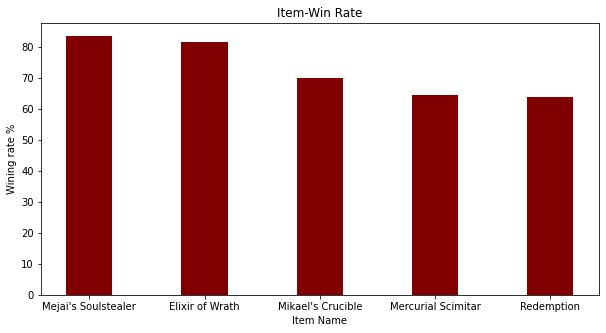

In [50]:
top_five_winning_items= sorted(item_rates_list, key = lambda x: x[1][0], reverse = True)
indices=[7,8,14,19,20]
top_five_winning_items = [top_five_winning_items[index] for index in indices]
names,values=get_name_value_win_rate(top_five_winning_items)
show(names,scale(values,100),"Item Name","Wining rate %","Item-Win Rate")

# Synergies Computation

In [332]:
import itertools
from operator import add
def champion_duos(row):
  duos = []
  team1 = []
  team2 = []
  is_team1_win = False
  is_team2_win = False
  for p in row['info']["participants"]:
    if(p["teamId"] == 100): 
      team_number = 0
    else: 
      team_number = 1
    if(team_number == 0):
      team1.append(p["championId"])
      is_team1_win = p["win"]
    else:
      team2.append(p["championId"])
      is_team2_win = p["win"]
  team1 = sorted(team1)
  team2 = sorted(team2)
  for c in list(itertools.combinations(team1, 2)):
    if is_team1_win:
      duos.append((c, 1))
    else:
      duos.append((c, 0))

  for c in list(itertools.combinations(team2, 2)):
    if is_team2_win:
      duos.append((c, 1))
    else:
      duos.append((c, 0))  
  return duos[0:5]
#champion_duos(matches_data.first())
duos_score = matches_data.rdd.flatMap(champion_duos).reduceByKey(add)
duos_score_list = duos_score.collect()
top_five_duos = sorted(duos_score_list, key = lambda x: x[1], reverse = True)[5:10]

In [334]:
item,c=zip(*top_five_duos)

In [352]:
def synergy_by_champion():
  item, c = zip(*top_five_duos)
  names=[]
  values=[]
  for i in item:
    names.append(get_champions_name(i[0])+'_'+get_champions_name(i[1]))
  for i in c:
    values.append(i)
  show(names,values,'Duo Champions Names','Synergy weights ','Synergy For  Champions Duo')

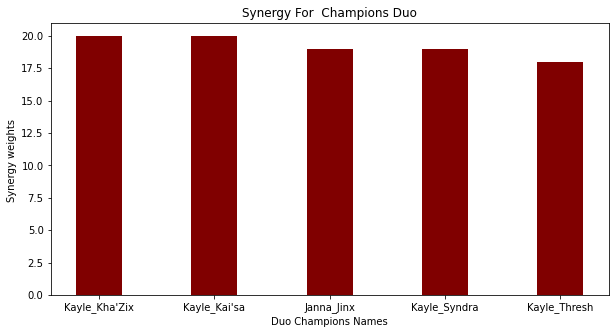

In [353]:
synergy_by_champion()

# Item Synergies With Champions


In [141]:
with open('/content/drive/MyDrive/champion_class.json') as f:
  data=json.load(f)
tags_id={}

for it in data:
  i={it['championId']:it['tags']}
  tags_id.update(i)


def item_syn(match):
  item_win=[]
  for part in match["info"]["participants"]:
    for item_num in range(7):
      item_win.append((part["item"+str(item_num)],(part["win"],part["championId"],tags_id.get(part["championName"]))))
  return item_win

def get_key_item(val):
    for key, value in items_id.items():
         if val == value:
             return key

def champion_item_synergies(static):
  champion_item_syn_rate= {} # championId : item syngery rate
  win_total=static[1][0].count(True)
  lose_total=static[1][0].count(False)
  total_games=win_total+lose_total
  for stats in static[1]:
    championId=stats[1]
    ishewon=stats[0]
    if(championId in champion_item_syn_rate): #if this champion played a match already +0.5
      champion_item_syn_rate[championId] += 0.5
    else:
      champion_item_syn_rate[championId] = 0.5   # if this is the first match for this player 0.5
    if(ishewon == True):
            champion_item_syn_rate[championId] += 1   # if ths player won the match 1

  item_synergies = []
  for championId, item_syn_rate in sorted(champion_item_syn_rate.items(), key=lambda x:x[1], reverse=True):
    item_synergies.append((championId, (item_syn_rate/total_games)))
  return  item_synergies[0:5]
items_champion = matches_data.rdd.flatMap(item_syn).groupByKey().mapValues(list)
item_champion_synergy = items_champion.map(lambda x:(x[0] ,champion_item_synergies(x))).filter(lambda x: x[0] is not None)
item_champion_list = item_champion_synergy.collect()

In [144]:
item, c = zip(*item_champion_list)
def synergy_by_item(search_item='Shard of True Ice'):
  item, c = zip(*item_champion_list)
  key=get_key_item(search_item)
  indx=item.index(int(key))
  rate=c[indx]
  names=[]
  values=[]
  for i in rate:
    names.append(get_champions_name(i[0]))
    values.append(i[1])
  show(names,values,'Champion Name','Synergy weights over total games ','Synergy For '+search_item+' Item With Champions')


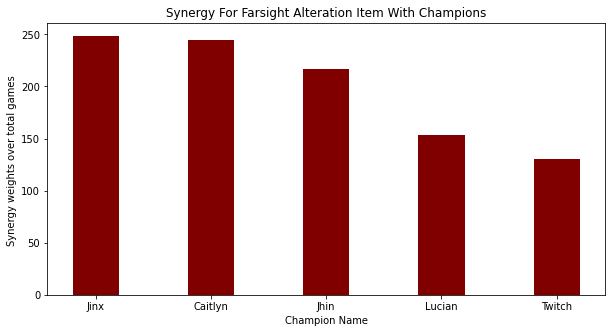

In [145]:
synergy_by_item('Farsight Alteration')

# Item  Synergies With Classes

In [210]:
def item_class_synergies(static):
  champion_item_syn_rate= {} # championId : item syngery rate
  win_total=static[1][0].count(True)
  lose_total=static[1][0].count(False)
  total_games=win_total+lose_total
  for stats in static[1]:
    if stats[2] != None:
      championId=stats[1]
      ishewon=stats[0]
      tags=stats[2]
      for class_item in tags:
        if(class_item in champion_item_syn_rate): #if this champion played a match already +0.5
          champion_item_syn_rate[class_item] += 0.5
        else:
          champion_item_syn_rate[class_item] = 0.5   # if this is the first match for this player 0.5
        if(ishewon == True):
                champion_item_syn_rate[class_item] += 1   # if ths player won the match 1
    else:
      pass

  item_synergies = []
  for class_it, item_syn_rate in sorted(champion_item_syn_rate.items(), key=lambda x:x[1], reverse=True):
    item_synergies.append((class_it, (item_syn_rate/total_games)))
  return   item_synergies[:5]

items_class = matches_data.rdd.flatMap(item_syn).groupByKey().mapValues(list)
item_class_synergy = items_class.map(lambda x:(x[0] ,item_class_synergies(x))).filter(lambda x: x[0] is not None)
item_class_list=item_class_synergy.collect()

In [211]:
def get_key_tag(tag):
    for key, val in items_id.items():
         if val == tag:
             return key
def synergy_by_item_class(search_item=''):
  item, c = zip(*item_class_list)
  key=get_key_tag(search_item)
  indx=item.index(int(key))
  rate=c[indx]
  names=[]
  values=[]
  for i in rate:
    names.append((i[0]))
    values.append(i[1])
  show(names,values,'Tags name','Synergy weights over total games ','Synergy For '+search_item+' Item With Classes')

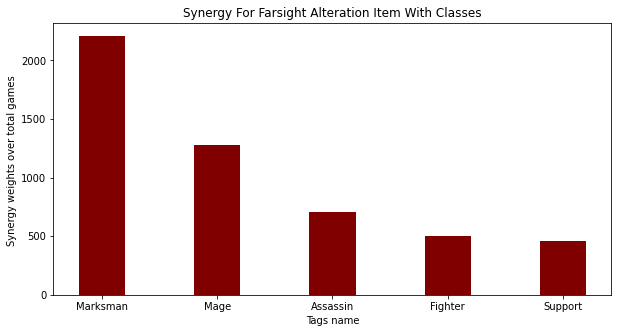

In [212]:
synergy_by_item_class('Farsight Alteration')


# Item Suggestion

In [221]:
with open('/content/items_info') as f:
  data_dragon=json.load(f)


In [293]:
def item_sugg(match):
  '''
  (items(0-6),winorlose)
  '''
  item_win=[]
  for part in match["info"]["participants"]:
    for item_num in range(7):
      try :
        id=str(part["item"+str(item_num)])
        if  (data_dragon['data'][id]['gold']['total'] >= 1000):
          item_win.append((part['championId'],(data_dragon['data'][id]['name'],part["win"])))
      except:
        pass
  return item_win

def champion_item_suggest(row):
  item_dict= {}
  for val in row[1]:
    if(val[0] in item_dict):
      item_dict[val[0]] += 0.5
    else:
      item_dict[val[0]] = 0.5
    
    if(val[0] == True):
            item_dict [val[0]] += 1

  c = []
  for k, r in sorted(item_dict.items(), key=lambda x:x[1], reverse=True):
    c.append((k, r))

  
  return (row[0], (c[:5]))

In [294]:
c_item = matches_data.rdd.flatMap(item_sugg).groupByKey().mapValues(list)
champion_item_suggestion = c_item.map(lambda x: champion_item_suggest(x))
c_item_list =  champion_item_suggestion.collect()

In [304]:
def get_id_by_name(name):
  ch=get_champions_name(0)
  for key,val in ch.items():
    if val==name:
      return key
def item_suggest(search_item=''):
  item, c = zip(*c_item_list)
  key=get_id_by_name(search_item)
  indx=item.index(int(key))
  rate=c[indx]
  names=[]
  values=[]
  for i in rate:
    names.append((i[0]))
    values.append(i[1])
  show(names,values,'Items Suggested','Synergy weights over total games ','Synergy For '+search_item+' Champion With Suggested Items')

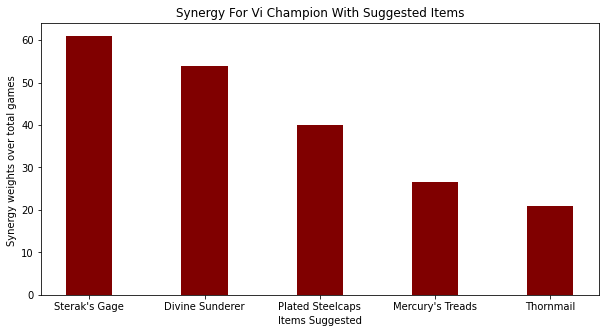

In [305]:
item_suggest('Vi')